# TDSE

We solve the time-dependent Schrödinger equation using the time-discretization method, by propagating the wavepacket or several wavepackets at the same time on the ordered grid of time steps. When the Hamiltonian can be split into a zero-order diagonal part and a perturbation, a split-operator technique can be used. For propagation, we use the Lanczos method, as implemented internally and using the [Expokit](https://www.maths.uq.edu.au/expokit/) Fortran library.

To initialize the TDSE solver, provide initial time `t_start`, terminal time `t_end`, time step `dt`, units of time `t_units`, and units of energy (Hamiltonian matrix) `enr_units`.

In [19]:
from richmol.tdse import TDSE

tdse = TDSE(t_start=0, t_end=200, dt=0.01, t_units="ps", enr_units="invcm")

The time grid can be generated using `time_grid` method, currently only equidistant grid is implemented. In the future, the type of grid can be set by providing a `grid_type` argument and external field.

In [20]:
print(tdse.time_grid())
print("min:", min(tdse.time_grid()), "mat:", max(tdse.time_grid()), "len", len(tdse.time_grid()))

[5.00000e-03 1.50000e-02 2.50000e-02 ... 1.99975e+02 1.99985e+02
 1.99995e+02]
min: 0.005 mat: 199.995 len 20000


## Initial state vectors

The initial wavepacket or set of wavepackets can be generated using `init_state` method, which takes as arguments Hamiltonian and temperature and returns a set of Hamiltonian's eigenfunctions weighted by a Boltzmann factor. If temperature is set to zero, only single ground state eigenvector is returned, if temperature is `None`, all eigenvectors without weights are returned. One can specify `thresh` argument to control the number of initial states with significant population. Only states (in ascending energy order) will be considered for which the sum of the normalized Boltzmann weights - 1 > `thresh`. One can also specify the zero-point energy  using `zpe` argument, by default the zero-point energy is set to the lowest eigenvalue.

To proceed, let's generate the molecular rotational solutions and matrix elements for OCS molecule

In [21]:
from richmol.rot import Molecule, solve, LabTensor
from richmol.convert_units import AUdip_x_Vm_to_invcm, AUpol_x_Vm_to_invcm

ocs = Molecule()

ocs.XYZ = ("angstrom",
           "C",  0.0,  0.0,  -0.522939783141,
           "O",  0.0,  0.0,  -1.680839357,
           "S",  0.0,  0.0,  1.037160128)

# molecular-frame dipole moment (in au)
ocs.dip = [0, 0, -0.31093]

# molecular-frame polarizability tensor (in au)
ocs.pol = [[25.5778097, 0, 0], [0, 25.5778097, 0], [0, 0, 52.4651140]]

Jmax = 5
sol = solve(ocs, Jmax=Jmax)

# laboratory-frame dipole moment operator
dip = LabTensor(ocs.dip, sol)

# laboratory-frame polarizability tensor
pol = LabTensor(ocs.pol, sol)

# field-free Hamiltonian
h0 = LabTensor(ocs, sol)

# matrix elements of cos(theta)
cos = LabTensor("costheta", sol) 

# matrix elements of cos^2(theta)-1/3
cos2 = LabTensor("cos2theta", sol)

The initial state vectors at different temperatures can be generated as

In [23]:
# with default `thresh` = 1e-3
print(f"thresh {1e-3}")
for temp in (0, 0.5, 1, 2, 10):
    vecs = tdse.init_state(h0, temp=temp)
    print(f"T = {temp}  no. states = {len(vecs)}")

# with `thresh` = 1e-1 - neglect more states than above
print(f"\nthresh {1e-1}")
for temp in (0, 0.5, 1, 2, 10):
    vecs = tdse.init_state(h0, temp=temp, thresh=1e-1)
    print(f"T = {temp}  no. states = {len(vecs)}")

thresh 0.001
T = 0  no. states = 1
T = 0.5  no. states = 13
T = 1  no. states = 24
T = 2  no. states = 35
T = 10  no. states = 35

thresh 0.1
T = 0  no. states = 1
T = 0.5  no. states = 3
T = 1  no. states = 8
T = 2  no. states = 15
T = 10  no. states = 30


In some cases when a dc field is combined with a microwave or a laser field, the initial molecular states are the so-called pendular states, which are the eigenstates of a dc-interaction Hamiltonian. They can be generated using `init_state` function as well

In [24]:
# dc field
dc = [1000, 0, 400000] # X, Y, Z components in V/m

fac1 = AUdip_x_Vm_to_invcm() # converts dipole(au) * field(V/m) into energy(cm^-1)

# dc-field interaction Hamiltonian
H = h0 - fac1 * dip * dc

for temp in (0, 0.5, 1, 2, 10):
    vecs = tdse.init_state(H, temp=temp)
    print(f"T = {temp}  no. states = {len(vecs)}")

T = 0  no. states = 1
T = 0.5  no. states = 13
T = 1  no. states = 24
T = 2  no. states = 35
T = 10  no. states = 35


## Time propagation

`update` method propagates wavepacket from one time point to another. It takes as arguments Hamiltonian and set of wavepacket vectors and returns updated wavepacket vectors and time. In the following example we use `update` to calculated dynamics of OCS in oscillating laser field

number of initial vectors 1
time 0.005 ps
time 10.005 ps
time 20.005 ps
time 30.005 ps
time 40.005 ps
time 50.005 ps
time 60.005 ps
time 70.005 ps
time 80.005 ps
time 90.005 ps


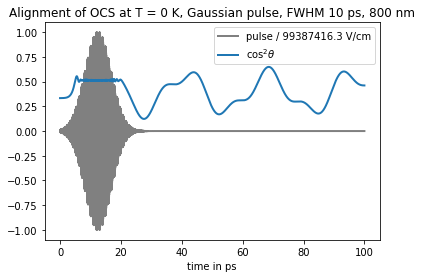

In [29]:
import numpy as np
from scipy.constants import speed_of_light
import matplotlib.pyplot as plt

# set up 800 nm 10ps long Gaussian pulse
nm = 1e-9
omega = 800 * nm # in nm
omega = 2 * np.pi * speed_of_light / omega * 1e-12  # in 1/ps
FWHM = 10 # ps
t0 = 2.5 * FWHM / 2
amp = 1e10 # in V/m
field = lambda t: [0, 0, amp * np.exp(-4*np.log(2)*(t-t0)**2/FWHM**2) * np.cos(omega*t)]

# molecule-laser interaction Hamiltonian
H = -1/2 * pol * AUpol_x_Vm_to_invcm() # `AUpol_x_Vm_to_invcm` converts polarizability(au) * field(V/m) into energy(cm^-1)

# set up propagation parameters, from time 0 to 100 ps, with a time step of 10 fs
tdse = TDSE(t_start=0, t_end=100, dt=0.01, t_units="ps", enr_units="invcm")

# initial vector - rotational ground state (at T=0 K)
temp = 0
vecs = tdse.init_state(h0, temp=temp)
print(f"number of initial vectors {len(vecs)}")

# matrix elements of cos^2(theta) in sparse matrix form - dynamics observable
cos2mat = cos2.tomat(form="full", cart="0")
cos2_expval = [] # array to keep expectation values of cos^2(theta) on time grid

# run time propagation

for i, t in enumerate(tdse.time_grid()):

    # multiply Hamiltonian with field
    H.field(field(t), thresh=1e3) # field below 1e3 V/m consider as zero

    # update vector
    vecs, t_ = tdse.update(H+h0, vecs=vecs, matvec_lib='scipy')
    #vecs, t_ = tdse.update(H, H0=h0, vecs=vecs, matvec_lib='scipy') # for split-operator approach

    # expectation value of cos^2(theta)
    expval = sum( np.dot( np.conj(vecs[i][:]), cos2mat.dot(vecs[i][:]) ) for i in range(len(vecs)) ) + 1/3
    cos2_expval.append(expval.real)

    if i % 1000 == 0:
        print(f"time {t} ps")

# plot expectation values of cos^2(theta)
f = np.array([field(t)[2] for t in tdse.time_grid()])
plt.plot(tdse.time_grid(), f/np.max(f), 'gray', linewidth=2, label=f"pulse / {round(np.max(f)/1e2, 1)} V/cm")
plt.plot(tdse.time_grid(), cos2_expval, linewidth=2, label="$\cos^2\\theta$")
plt.title(f"Alignment of OCS at T = {temp} K, Gaussian pulse, FWHM {FWHM} ps, 800 nm")
plt.xlabel("time in ps")
plt.legend()
plt.show()

To invoke the split-operator approach, the diagonal zero-order Hamiltonian `h0` should be passed into `update` as a keyword argument "H0", i.e. `tdse.update(H, H0=h0, vecs=vecs)` instead of `tdse.update(H+h0, vecs=vecs)`